# Heartbeat Sounds

### [Classifying heartbeat anomalies from stethoscope audio](https://www.kaggle.com/kinguistics/heartbeat-sounds)

### Imports

In [1]:
import librosa
import os
import pandas as pd
import numpy as np
import fnmatch
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
import librosa.display
import shutil
plt.ioff()

PATH = "C:\\Users\\frapo\\Downloads\\heartbeat-sounds"
PATH = "/tmp/data"

### Functions

In [3]:
def load_wave(fname):
    y, sr = librosa.load(os.path.join(PATH, fname))
    return y

def build_dataset():
    path_to_ = os.path.join(PATH, "heartbeats.pkl")
    if os.path.isfile(path_to_):
        df = pd.read_pickle(path_to_)
    else:
        murmurs = ['set_b/'+ m for m in fnmatch.filter(os.listdir(PATH+'/set_b'), 'murmur*.wav')]
        murmurs += ['set_a/'+ m for m in fnmatch.filter(os.listdir(PATH+'/set_a'), 'murmur*.wav')]
        murmurs += murmurs
        labels = ["murmur"] * len(murmurs)
        
        normals = ['set_b/'+ m for m in fnmatch.filter(os.listdir(PATH+'/set_b'), 'normal*.wav')]
        normals += ['set_a/'+ m for m in fnmatch.filter(os.listdir(PATH+'/set_a'), 'normal*.wav')]
        labels += ["normal"] * len(normals)
        
        df = pd.DataFrame({"fname": murmurs+normals, "label": labels})
        df["array"] = df.fname.apply(load_wave)
        df["len_series"] = df["array"].apply(len)
        df['image_names'] = df.fname.apply(lambda x: x.replace("/", "-").replace("wav", "jpg"))
        df = df.sample(frac=1)
        df.to_pickle(path_to_)
    
    return df

def repeat_to_length(arr, length):
    """Repeats the numpy 1D array to given length, and makes datatype float"""
    result = np.empty((length, ), dtype = 'float32')
    l = len(arr)
    pos = 0
    while pos + l <= length:
        result[pos:pos+l] = arr
        pos += l
    if pos < length:
        result[pos:length] = arr[:length-pos]
    return result

def explore_heartbeat(i):
    print(f"i: {i}")
    label = data.iloc[i].label
    fname = data.iloc[i].fname
    print(f"label: {label}; fname: {fname}")
    if label not in fname: return "Incostintent label"
    
    y, sr = librosa.load(os.path.join(PATH, fname))
    d = librosa.get_duration(y=y, sr=sr)
    print(f"Before padding sr: {sr}; len: {len(y)}; duration (s): {d}")
    
    y_ext = repeat_to_length(y, MAX_LEN)
    d = librosa.get_duration(y=y_ext, sr=sr)
    print(f"After padding sr: {sr}; len: {len(y_ext)}; duration: {d}")
    
    fig, ax = plt.subplots(figsize=(15, 3))
    librosa.display.waveplot(y, sr=sr)
    ax.set_title(f'label={label}; waveplot')
    
    X = librosa.stft(y)
    Xdb = librosa.amplitude_to_db(abs(X))
    fig, ax = plt.subplots(figsize=(15, 5))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    ax.set_title(f'label={label}; spectrogram: stft, amp2db, log')
    
    mfccs = librosa.feature.mfcc(y, sr=sr)
    fig, ax = plt.subplots(figsize=(15, 5))
    librosa.display.specshow(mfccs, sr=sr, x_axis='time', y_axis='log')
    ax.set_title(f'label={label}; spectrogram: mfcc, log')

    mel_spec = librosa.feature.melspectrogram(y, sr=sr, fmin=10, fmax=2000, power=1.0)
    mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)    
    fig, ax = plt.subplots(figsize=(15, 5))
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='log')
    ax.set_title(f'label={label}; spectrogram: melspectrogram, amp2db, log, fmax=2k hz')
    
    plt.show()
    
    return fname, Xdb, y

def get_melspectrogram(y, sr):
    mel_spec = librosa.feature.melspectrogram(y, sr=sr, fmin=10, fmax=2000, power=1.0)
    mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)  
    return mel_spec_db

def produce_spect_image(spec, sr, name):
    fig, ax = plt.subplots(figsize=(15, 5))
    librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log')    
    ax.axis('off')
    plt.savefig(name, bbox_inches=None, pad_inches=0)
    plt.close(fig)
    
def load_and_pad(fname):
    y, sr = librosa.load(fname)
    y = repeat_to_length(y, MAX_LEN)
    return y, sr

def save_spectrograms(df):
    
    directory = os.path.join(PATH, "spects")
    if os.path.exists(directory): shutil.rmtree(directory)
    os.makedirs(directory)
    
    for i, row in df.iterrows():
        fname = os.path.join(PATH, row.fname)
        image_name = os.path.join(directory, row.image_names)
        
        y, sr = load_and_pad(fname)
        spec = get_melspectrogram(y, sr)
        produce_spect_image(spec, sr, image_name)
        
    mxn = df.copy().reset_index()
    mxn["is_murmur"] = mxn.label.apply(lambda x: int(x == "murmur"))
    
    return mxn[["index", "is_murmur", "image_names"]]

def save_lst(x, name):
    x.to_csv(os.path.join(PATH, 'temp.lst'), index=False, header=None, sep='\t')
    
    with open(os.path.join(PATH, 'temp.lst'), "rt") as fin:
        with open(os.path.join(PATH, name), "wt") as fout:
            for line in fin:
                fout.write(line.replace('"', ''))

### Load dataset and explore

In [4]:
data = build_dataset()
MAX_LEN = max(data["len_series"])

assert MAX_LEN == 614468
assert isinstance(data.array[0].sum(), np.float32)
assert data.shape == (609, 5)

In [5]:
data.sample(5)

,fname,label,array,len_series,image_names
18,set_b/murmur_noisymurmur_231_1308748318393_A.wav,murmur,"[0.0146143, 0.016386967, 0.017439434, 0.017774...",71928,set_b-murmur_noisymurmur_231_1308748318393_A_b...
466,set_b/normal__173_1307973611151_B.wav,normal,"[0.05408236, 0.061713282, 0.06718626, 0.070492...",63934,set_b-normal__173_1307973611151_B.jpg
246,set_a/murmur__201108222238.wav,murmur,"[-0.008955993, -0.014323477, -0.013486341, -0....",174979,set_a-murmur__201108222238_bis.jpg
584,set_a/normal__201102270940.wav,normal,"[-0.0005540601, -0.0009245227, -0.00035700403,...",198450,set_a-normal__201102270940.jpg
519,set_b/normal__215_1308245664733_C.wav,normal,"[0.0006322928, 0.0007833429, 0.0009129261, 0.0...",65621,set_b-normal__215_1308245664733_C.jpg


In [6]:
data.label.value_counts()

normal    351
murmur    258
Name: label, dtype: int64

i: 103
label: normal; fname: set_b/normal_noisynormal_246_1309199278902_D.wav
Before padding sr: 22050; len: 518881; duration (s): 23.532018140589567
After padding sr: 22050; len: 614468; duration: 27.86702947845805


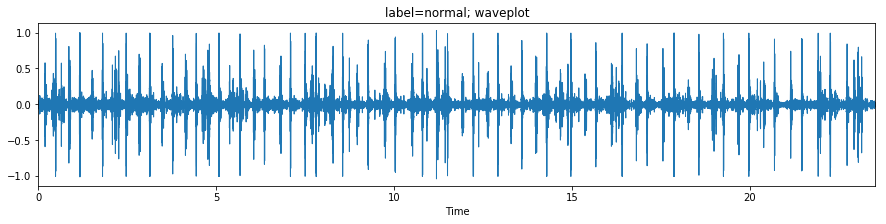

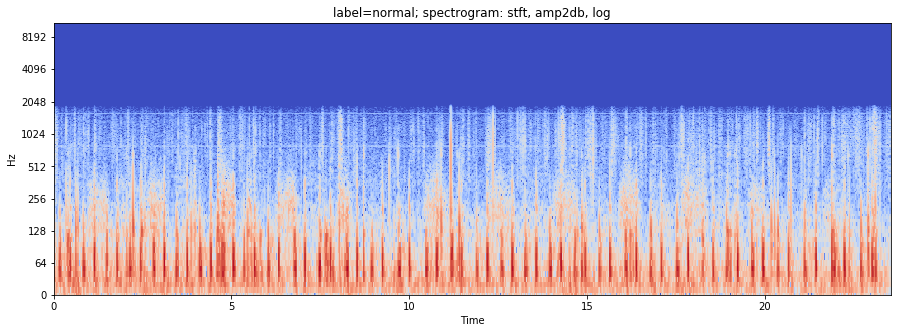

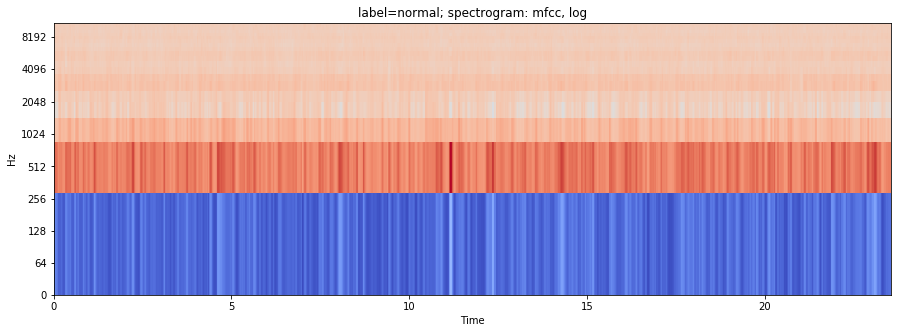

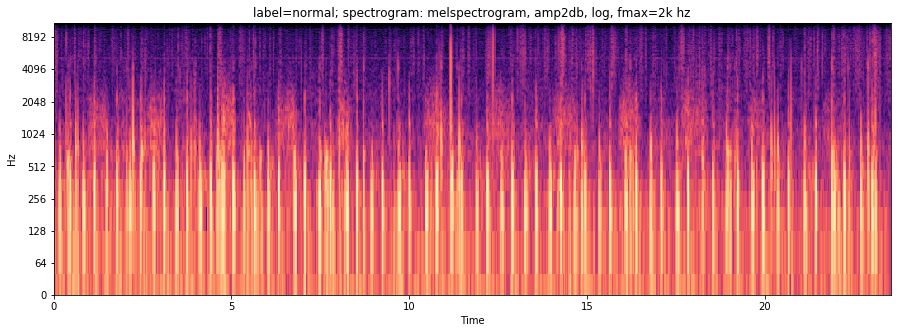

In [8]:
i = np.random.randint(low=0, high=(len(data)-1))
fname, Xdb, y = explore_heartbeat(i)
ipd.Audio(os.path.join(PATH, fname))

### Prepare dataset for Deep Learning

In [11]:
lst = save_spectrograms(data)

In [13]:
assert lst.shape[0] == data.shape[0]

In [17]:
raw_train = lst.sample(int(len(lst)*.8), random_state=42).sample(frac=1)
raw_valid = lst.loc[~lst.index.isin(raw_train.index)].sample(frac=1)

raw_train.shape, raw_valid.shape

((487, 3), (122, 3))

In [20]:
raw_train.is_murmur.sum()/len(raw_train), raw_valid.is_murmur.sum()/len(raw_valid)

(0.4394250513347023, 0.36065573770491804)

In [21]:
save_lst(raw_train, 'train.lst')
save_lst(raw_valid, 'valid.lst')

In [10]:
! head {PATH}/train.lst

168	1	set_b-murmur__160_1307100683334_B.jpg
94	1	set_b-murmur__293_1311680805936_B1.jpg
256	1	set_a-murmur__201108222256.jpg
268	0	set_b-normal_noisynormal_109_1305653972028_A.jpg
87	1	set_b-murmur__281_1311165683454_A.jpg
37	1	set_b-murmur__156_1306936373241_B.jpg
458	0	set_b-normal__168_1307970069434_A.jpg
0	1	set_b-murmur_noisymurmur_135_1306428972976_A.jpg
251	1	set_a-murmur__201108222248.jpg
526	0	set_b-normal__220_1308250132896_C.jpg


## Deep Learning

### Taking a look at a batch

In [16]:
from mxnet import gluon, init, nd, autograd
from mxnet.gluon import data as gdata, loss as gloss, model_zoo
from mxnet.gluon import utils as gutils
import subprocess
import time
from skimage import io

import mxnet as mx
import cv2

In [10]:
def standard_transform(data, label):
    data = data.astype('float32')
    augs = mx.image.CreateAugmenter(data_shape=(3, 360, 360))
    for aug in augs:
        data = aug(data)
    return data, label

def show_batch(rec_file):
    dataset = mx.gluon.data.vision.ImageRecordDataset(os.path.join(PATH, rec_file),
                                                     transform=standard_transform)
    loader = mx.gluon.data.DataLoader(dataset, batch_size=64, shuffle=True)
    x, y = next(iter(loader))
    fig, axes = plt.subplots(3, 4, figsize=(12, 8))
    for i,ax in enumerate(axes.flat):
        im = (x[i])
        labels = ['Normal', 'Murmur'][int(y[i].asnumpy()[0])]
        title = labels
        ax.set_title(title)
        ax.set_axis_off()
        ax.imshow((im.clip(0, 255)/255).asnumpy())

In [12]:
training_dataset = mx.gluon.data.vision.ImageRecordDataset(os.path.join(PATH, 'train.rec'), transform=standard_transform)
train_iter = mx.gluon.data.DataLoader(training_dataset, batch_size=32, shuffle=True)

In [13]:
x, y = next(iter(train_iter))
x.shape, y.shape

((32, 360, 360, 3), (32,))

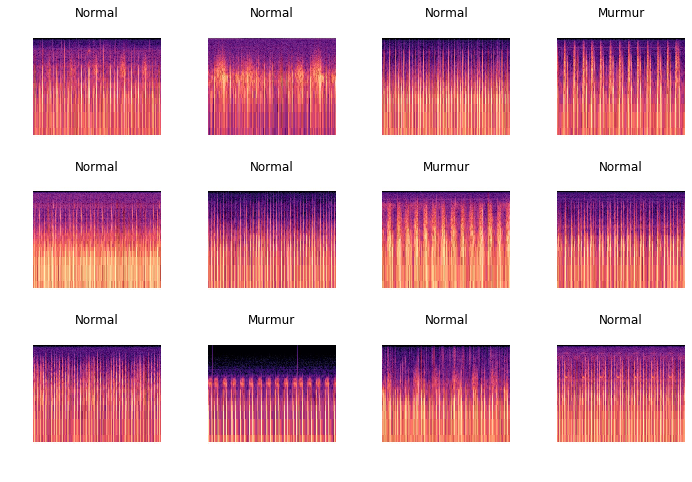

In [14]:
show_batch('train.rec')

### Training a ResNet in SageMaker

In [2]:
import sagemaker

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

In [15]:
from sagemaker.mxnet import MXNet
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
import random_tuner as rt

In [38]:
m = MXNet('heartsound_mxnet.py', 
          role=role, 
          train_instance_count=1, 
          py_version='py3',
          train_instance_type='ml.p2.xlarge',
          hyperparameters={'batch_size': 16, 
                           'epochs': 5})

In [39]:
m.fit("s3://heartbeat-sounds")

2019-06-05 15:45:57 Starting - Starting the training job...
2019-06-05 15:45:59 Starting - Launching requested ML instances.........
2019-06-05 15:47:31 Starting - Preparing the instances for training...
2019-06-05 15:48:26 Downloading - Downloading input data.........
2019-06-05 15:49:29 Training - Downloading the training image.
2019-06-05 15:50:01,010 INFO - root - running container entrypoint
2019-06-05 15:50:01,010 INFO - root - starting train task
2019-06-05 15:50:01,031 INFO - container_support.training - Training starting
2019-06-05 15:50:02,271 WARNING - mxnet_container.train - #033This required structure for training scripts will be deprecated with the next major release of MXNet images. The train() function will no longer be required; instead the training script must be able to be run as a standalone script. For more information, see https://github.com/aws/sagemaker-python-sdk/tree/master/src/sagemaker/mxnet#updating-your-mxnet-training-script.#033
2019-06-05 15:50:03,691 IN

### Bayesian Hyper-Parameter Optimization in SageMaker

In [22]:
mt = MXNet('heartsound_mxnet.py', 
          role=role, 
          train_instance_count=1, 
          py_version='py3',
          train_instance_type='ml.p2.xlarge',
          hyperparameters={'batch_size': 16})

No framework_version specified, defaulting to version 1.2. This is not the latest supported version. If you would like to use version 1.3, please add framework_version=1.3 to your constructor.


In [23]:
hyperparameter_ranges = {'learning_rate': ContinuousParameter(0.0001, 0.1),
                         'momentum': ContinuousParameter(0., 0.99),
                         'wd': ContinuousParameter(0., 0.001),
                         'epochs': IntegerParameter(5, 10),
                         'opt': CategoricalParameter(['sgd', 'adam'])}

In [24]:
objective_metric_name = 'Validation-accuracy'
metric_definitions = [{'Name': 'Validation-accuracy',
                       'Regex': 'validation: accuracy=([0-9\\.]+)'}]

In [25]:
tuner = HyperparameterTuner(mt,
                            objective_metric_name,
                            hyperparameter_ranges,
                            metric_definitions,
                            max_jobs=15)

In [26]:
tuner.fit("s3://heartbeat-sounds")

In [31]:
bayes_metrics = sagemaker.HyperparameterTuningJobAnalytics(tuner._current_job_name).dataframe()
bayes_metrics.sort_values(['FinalObjectiveValue'], ascending=False, inplace=True)

In [36]:
bayes_metrics.rename(index=str, columns={"FinalObjectiveValue": "validation_accuracy"}, inplace=True)
bayes_metrics[["validation_accuracy", "epochs", "learning_rate", "momentum", "opt", "wd"]]

,validation_accuracy,epochs,learning_rate,momentum,opt,wd
14,0.964286,10.0,0.000435,0.850335,"""adam""",0.000869
4,0.945312,9.0,0.000136,0.959620,"""sgd""",0.000507
3,0.919643,10.0,0.000763,0.974411,"""sgd""",0.000799
7,0.919643,10.0,0.001152,0.959002,"""adam""",0.000957
12,0.898438,8.0,0.002237,0.914738,"""adam""",0.000920
0,0.892857,5.0,0.000120,0.988601,"""sgd""",0.000000
1,0.892857,10.0,0.000105,0.989206,"""sgd""",0.000866
9,0.892857,10.0,0.009198,0.419034,"""adam""",0.000981
11,0.890625,9.0,0.000900,0.786290,"""adam""",0.000246
10,0.883929,10.0,0.000213,0.980358,"""adam""",0.000785
